# %% [markdown]
# # 🎗️ BREAST CANCER PREDICTION PIPELINE
# ## Complete ML System - From Data to Deployment
# 
# **Objective:** Predict breast cancer (Malignant/Benign) with 95%+ accuracy
# **Dataset:** Wisconsin Breast Cancer Database
# **Features:** 30 cell nucleus characteristics (radius, texture, perimeter, area, smoothness, etc.)
# **Algorithms:** SVM, Logistic Regression, Random Forest, XGBoost
# **Author:** Your Name | **Date:** 2024

In [1]:
# %% [markdown]
# ## 1. Environment Setup

# %%
import sys, os
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config.settings import ProjectConfig
from src.utils.logger import setup_logging

config = ProjectConfig.load("cancer")
logger = setup_logging("cancer_pipeline")
logger.info("✅ Breast cancer prediction pipeline initialized")
print(f"✅ Working directory: {os.getcwd()}")

2026-02-25 13:38:24 - cancer_pipeline - INFO - ✅ Breast cancer prediction pipeline initialized
✅ Working directory: d:\CodeAlpha_tasks\Disease_Prediction_System\notebooks


In [2]:
# %% [markdown]
# ## 2. Data Loading & Validation

# %%
from src.data.loader import DataLoader
from src.data.validator import DataValidator

loader = DataLoader(config)
df = loader.load_breast_cancer()
validator = DataValidator(config)
report = validator.generate_quality_report(df)
print(f"✅ Dataset loaded: {df.shape[0]} patients, {df.shape[1]} features")
print(f"📊 Features: Mean radius, texture, perimeter, area, smoothness, ...")

✅ Dataset loaded: 569 patients, 31 features
📊 Features: Mean radius, texture, perimeter, area, smoothness, ...


In [12]:
# %% [markdown]
# ## 3. Initial Data Inspection

# %%
print("📊 FIRST 5 ROWS (first 10 features):")
display(df.iloc[:, :10].head())

print("\n📊 DATA INFO:")
print(df.info())

print("\n📊 BASIC STATISTICS (first 5 features):")
display(df.iloc[:, :5].describe().round(2))

📊 FIRST 5 ROWS (first 10 features):


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883



📊 DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_s

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
count,569.00,569.00,569.00,569.00,569.00
mean,14.13,19.29,91.97,654.89,0.10
std,3.52,4.30,24.30,351.91,0.01
min,6.98,9.71,43.79,143.50,0.05
25%,11.70,16.17,75.17,420.30,0.09
50%,13.37,18.84,86.24,551.10,0.10
75%,15.78,21.80,104.10,782.70,0.11
max,28.11,39.28,188.50,2501.00,0.16


In [13]:
# %% [markdown]
# ## 4. Missing Values Analysis

# %%
missing = pd.DataFrame({
    'Column': df.columns,
    'Missing': df.isnull().sum().values,
    'Percentage': (df.isnull().sum() / len(df) * 100).values
}).sort_values('Percentage', ascending=False)

print("🔍 MISSING VALUES REPORT:")
if missing['Missing'].sum() > 0:
    display(missing[missing['Missing'] > 0])
else:
    print("✅ No missing values found!")

print(f"\n📊 Total missing: {df.isnull().sum().sum()} cells")
print(f"📊 Complete cases: {len(df.dropna())}/{len(df)}")

🔍 MISSING VALUES REPORT:
✅ No missing values found!

📊 Total missing: 0 cells
📊 Complete cases: 569/569


In [14]:
# %% [markdown]
# ## 5. Duplicate Check

# %%
duplicates = df.duplicated().sum()
print(f"📊 DUPLICATE ROWS: {duplicates}")
print(f"Percentage: {(duplicates/len(df))*100:.2f}%")

if duplicates > 0:
    print("⚠️ Duplicates found - will remove during preprocessing")
else:
    print("✅ No duplicates found")

📊 DUPLICATE ROWS: 0
Percentage: 0.00%
✅ No duplicates found


In [15]:
# %% [markdown]
# ## 6. Target Variable Distribution

# %%
target_dist = df['target'].value_counts()
target_pct = df['target'].value_counts(normalize=True) * 100

print("🎯 TARGET DISTRIBUTION:")
print(f"Benign:     {target_dist[0]} ({target_pct[0]:.1f}%)")
print(f"Malignant:  {target_dist[1]} ({target_pct[1]:.1f}%)")

if target_pct.min() < 30:
    print("⚠️ Mildly imbalanced - may apply SMOTE if needed")

🎯 TARGET DISTRIBUTION:
Benign:     357 (62.7%)
Malignant:  212 (37.3%)


In [7]:
# %% [markdown]
# ## 7. Data Types Analysis

# %%
dtype_df = pd.DataFrame({
    'Column': df.columns[:10],  # First 10 columns
    'Type': df.dtypes.values[:10],
    'Unique': [df[col].nunique() for col in df.columns[:10]]
})

print("📊 DATA TYPES (first 10 columns):")
display(dtype_df)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n✅ All {len(numeric_cols)} columns are numeric")

📊 DATA TYPES (first 10 columns):


,Column,Type,Unique
0,radius_mean,float64,456
1,texture_mean,float64,479
2,perimeter_mean,float64,522
3,area_mean,float64,539
4,smoothness_mean,float64,474
5,compactness_mean,float64,537
6,concavity_mean,float64,537
7,concave points_mean,float64,542
8,symmetry_mean,float64,432
9,fractal_dimension_mean,float64,499



✅ All 31 columns are numeric


In [16]:
# %% [markdown]
# ## 8. Feature Groups Understanding

# %%
feature_groups = {
    'mean': [col for col in df.columns if 'mean' in col.lower() or '_1' in col],
    'se': [col for col in df.columns if 'se' in col.lower() or '_2' in col],
    'worst': [col for col in df.columns if 'worst' in col.lower() or '_3' in col]
}

print("📊 FEATURE GROUPS:")
for group, cols in feature_groups.items():
    print(f"\n{group.upper()} features ({len(cols)}):")
    print(f"   {', '.join(cols[:3])}...")

print("\n📌 Note: Features are measurements of cell nuclei:")
print("   - Mean: Average value")
print("   - SE: Standard Error")
print("   - Worst: Largest value")

📊 FEATURE GROUPS:

MEAN features (10):
   radius_mean, texture_mean, perimeter_mean...

SE features (10):
   radius_se, texture_se, perimeter_se...

WORST features (10):
   radius_worst, texture_worst, perimeter_worst...

📌 Note: Features are measurements of cell nuclei:
   - Mean: Average value
   - SE: Standard Error
   - Worst: Largest value


In [17]:
# %% [markdown]
# ## 9. Statistical Summary by Feature Group

# %%
for group_name, cols in feature_groups.items():
    if cols:
        print(f"\n📈 {group_name.upper()} FEATURES SUMMARY:")
        group_stats = df[cols].describe().T[['mean', 'std', 'min', 'max']].round(2)
        display(group_stats.head())


📈 MEAN FEATURES SUMMARY:


,mean,std,min,max
radius_mean,14.13,3.52,6.98,28.11
texture_mean,19.29,4.30,9.71,39.28
perimeter_mean,91.97,24.30,43.79,188.50
area_mean,654.89,351.91,143.50,2501.00
smoothness_mean,0.10,0.01,0.05,0.16



📈 SE FEATURES SUMMARY:


,mean,std,min,max
radius_se,0.41,0.28,0.11,2.87
texture_se,1.22,0.55,0.36,4.88
perimeter_se,2.87,2.02,0.76,21.98
area_se,40.34,45.49,6.80,542.20
smoothness_se,0.01,0.00,0.00,0.03



📈 WORST FEATURES SUMMARY:


,mean,std,min,max
radius_worst,16.27,4.83,7.93,36.04
texture_worst,25.68,6.15,12.02,49.54
perimeter_worst,107.26,33.60,50.41,251.20
area_worst,880.58,569.36,185.20,4254.00
smoothness_worst,0.13,0.02,0.07,0.22


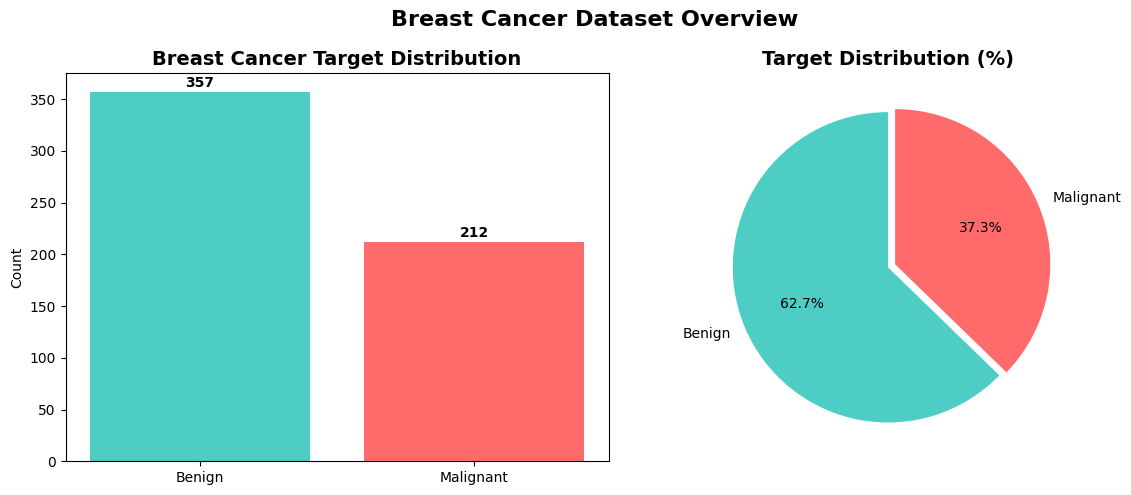

In [18]:
# %% [markdown]
# ## 10. Target Distribution Visualization

# %%
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars = ax1.bar(['Benign', 'Malignant'], target_dist.values, 
               color=['#4ECDC4', '#FF6B6B'])
ax1.set_title('Breast Cancer Target Distribution', fontweight='bold', fontsize=14)
ax1.set_ylabel('Count')
for bar, val in zip(bars, target_dist.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()+5, 
             str(val), ha='center', fontweight='bold')

ax2.pie(target_dist.values, labels=['Benign', 'Malignant'], 
        autopct='%1.1f%%', colors=['#4ECDC4', '#FF6B6B'],
        explode=(0, 0.05), startangle=90)
ax2.set_title('Target Distribution (%)', fontweight='bold', fontsize=14)

plt.suptitle('Breast Cancer Dataset Overview', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

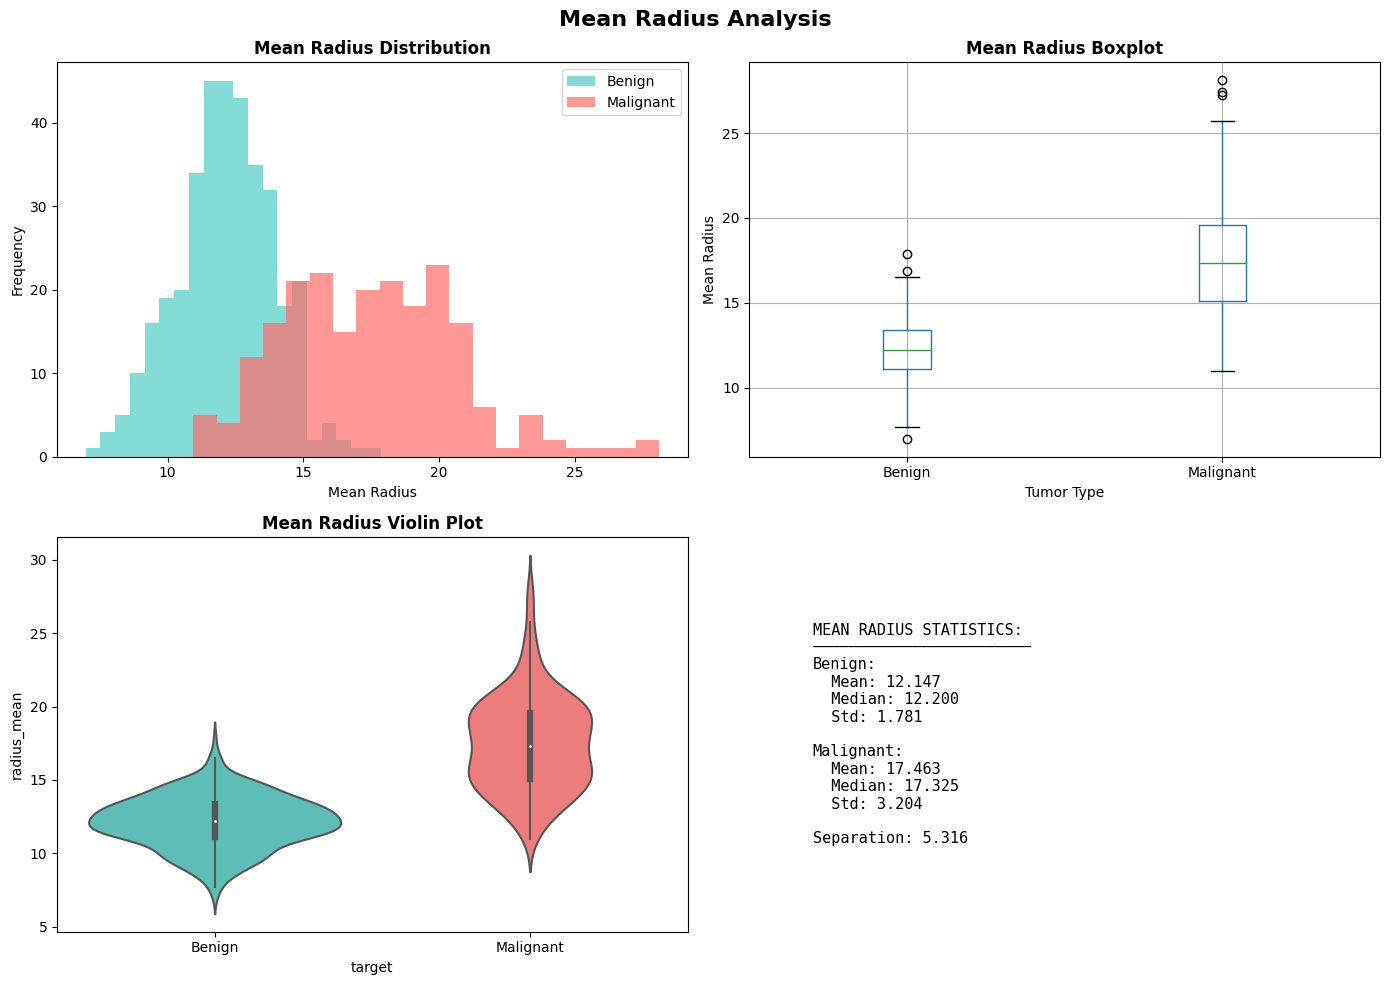

In [20]:
# %% [markdown]
# ## 11. Mean Radius Analysis (radius_mean)

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution by target
ax = axes[0, 0]
for target in [0, 1]:
    subset = df[df['target'] == target]['radius_mean']
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Mean Radius')
ax.set_ylabel('Frequency')
ax.set_title('Mean Radius Distribution', fontweight='bold')
ax.legend(['Benign', 'Malignant'])

# Boxplot
ax = axes[0, 1]
df.boxplot(column='radius_mean', by='target', ax=ax)
ax.set_title('Mean Radius Boxplot', fontweight='bold')
ax.set_xlabel('Tumor Type')
ax.set_ylabel('Mean Radius')
ax.set_xticklabels(['Benign', 'Malignant'])

# Violin plot
ax = axes[1, 0]
sns.violinplot(x='target', y='radius_mean', data=df, ax=ax,
               palette=['#4ECDC4', '#FF6B6B'])
ax.set_title('Mean Radius Violin Plot', fontweight='bold')
ax.set_xticklabels(['Benign', 'Malignant'])

# Statistics
ax = axes[1, 1]
ax.axis('off')
stats_text = f"""
MEAN RADIUS STATISTICS:
────────────────────────
Benign:
  Mean: {df[df['target']==0]['radius_mean'].mean():.3f}
  Median: {df[df['target']==0]['radius_mean'].median():.3f}
  Std: {df[df['target']==0]['radius_mean'].std():.3f}

Malignant:
  Mean: {df[df['target']==1]['radius_mean'].mean():.3f}
  Median: {df[df['target']==1]['radius_mean'].median():.3f}
  Std: {df[df['target']==1]['radius_mean'].std():.3f}

Separation: {df[df['target']==1]['radius_mean'].mean() - df[df['target']==0]['radius_mean'].mean():.3f}
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', family='monospace')

plt.suptitle('Mean Radius Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

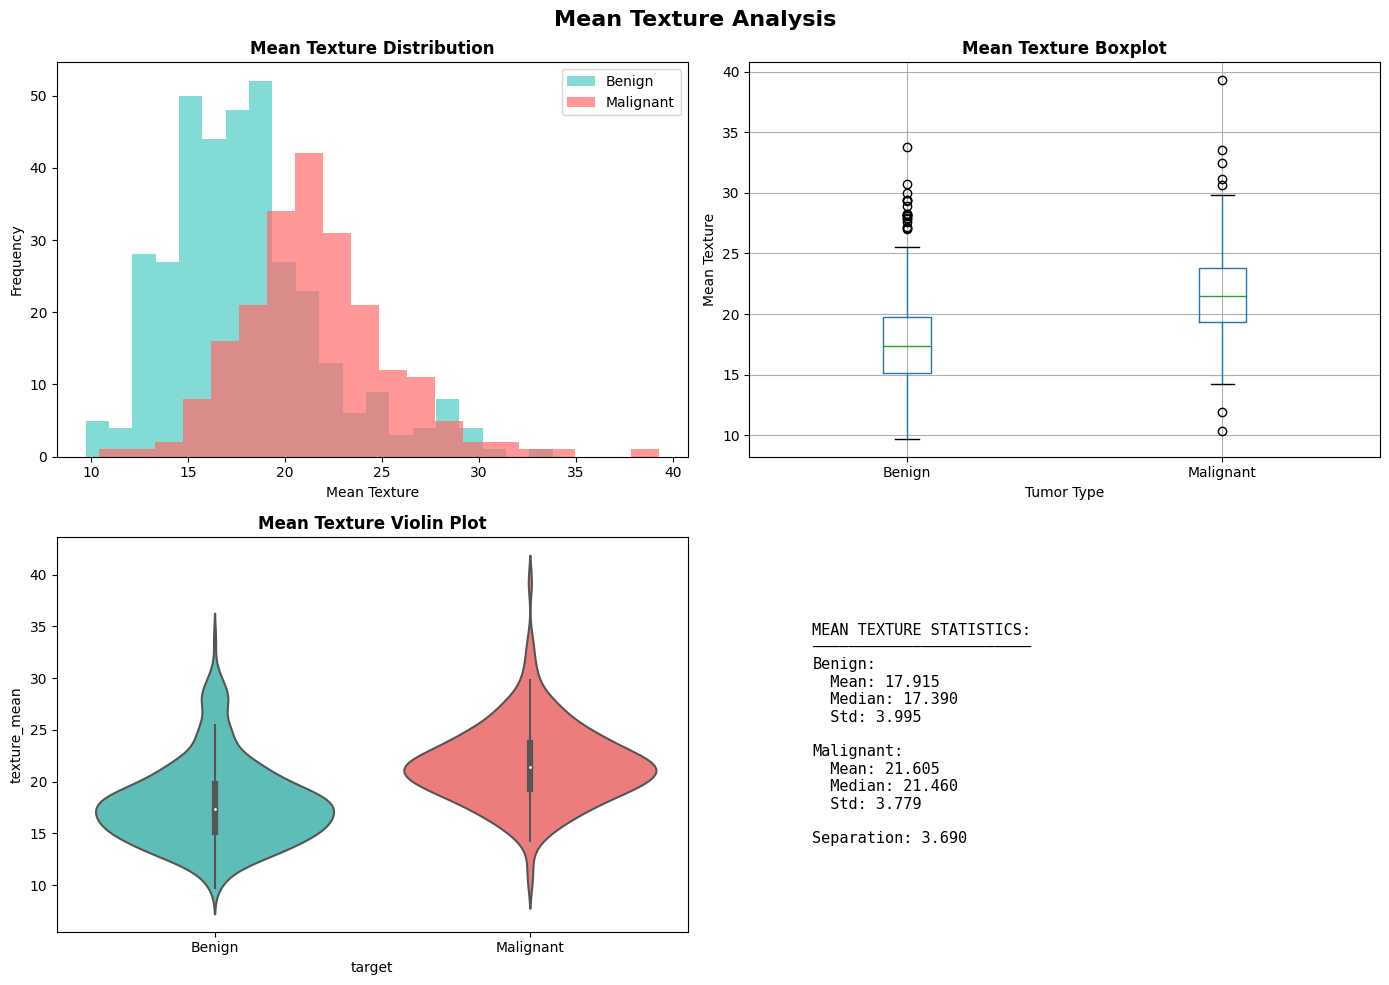

In [21]:
# %% [markdown]
# ## 12. Mean Texture Analysis (texture_mean)

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution by target
ax = axes[0, 0]
for target in [0, 1]:
    subset = df[df['target'] == target]['texture_mean']
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Mean Texture')
ax.set_ylabel('Frequency')
ax.set_title('Mean Texture Distribution', fontweight='bold')
ax.legend(['Benign', 'Malignant'])

# Boxplot
ax = axes[0, 1]
df.boxplot(column='texture_mean', by='target', ax=ax)
ax.set_title('Mean Texture Boxplot', fontweight='bold')
ax.set_xlabel('Tumor Type')
ax.set_ylabel('Mean Texture')
ax.set_xticklabels(['Benign', 'Malignant'])

# Violin plot
ax = axes[1, 0]
sns.violinplot(x='target', y='texture_mean', data=df, ax=ax,
               palette=['#4ECDC4', '#FF6B6B'])
ax.set_title('Mean Texture Violin Plot', fontweight='bold')
ax.set_xticklabels(['Benign', 'Malignant'])

# Statistics
ax = axes[1, 1]
ax.axis('off')
stats_text = f"""
MEAN TEXTURE STATISTICS:
────────────────────────
Benign:
  Mean: {df[df['target']==0]['texture_mean'].mean():.3f}
  Median: {df[df['target']==0]['texture_mean'].median():.3f}
  Std: {df[df['target']==0]['texture_mean'].std():.3f}

Malignant:
  Mean: {df[df['target']==1]['texture_mean'].mean():.3f}
  Median: {df[df['target']==1]['texture_mean'].median():.3f}
  Std: {df[df['target']==1]['texture_mean'].std():.3f}

Separation: {df[df['target']==1]['texture_mean'].mean() - df[df['target']==0]['texture_mean'].mean():.3f}
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', family='monospace')

plt.suptitle('Mean Texture Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

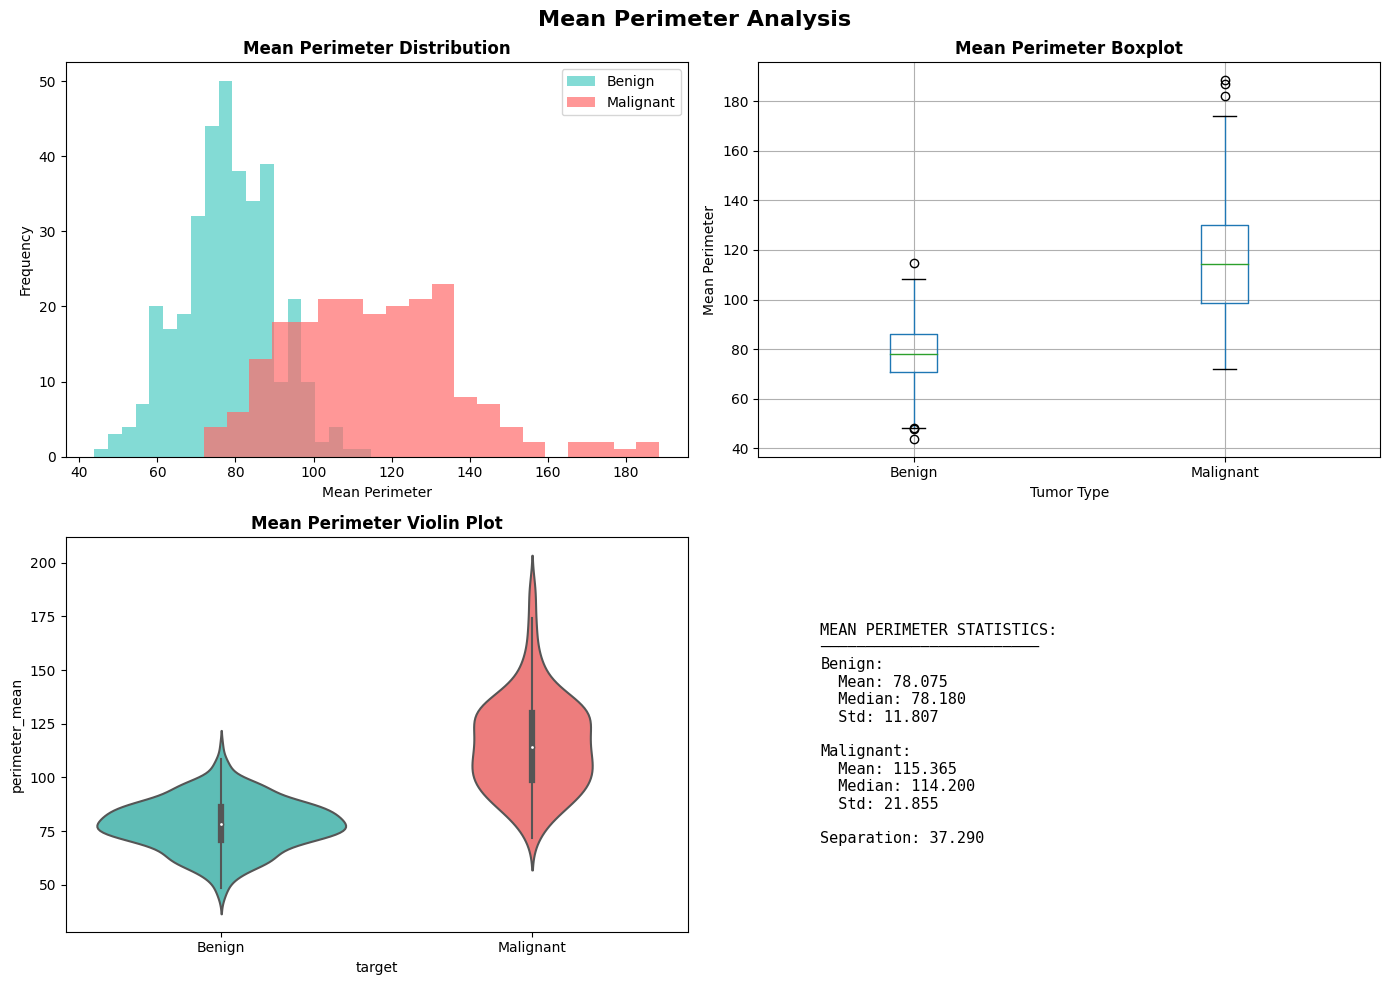

In [22]:
# %% [markdown]
# ## 13. Mean Perimeter Analysis (perimeter_mean)

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution by target
ax = axes[0, 0]
for target in [0, 1]:
    subset = df[df['target'] == target]['perimeter_mean']
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Mean Perimeter')
ax.set_ylabel('Frequency')
ax.set_title('Mean Perimeter Distribution', fontweight='bold')
ax.legend(['Benign', 'Malignant'])

# Boxplot
ax = axes[0, 1]
df.boxplot(column='perimeter_mean', by='target', ax=ax)
ax.set_title('Mean Perimeter Boxplot', fontweight='bold')
ax.set_xlabel('Tumor Type')
ax.set_ylabel('Mean Perimeter')
ax.set_xticklabels(['Benign', 'Malignant'])

# Violin plot
ax = axes[1, 0]
sns.violinplot(x='target', y='perimeter_mean', data=df, ax=ax,
               palette=['#4ECDC4', '#FF6B6B'])
ax.set_title('Mean Perimeter Violin Plot', fontweight='bold')
ax.set_xticklabels(['Benign', 'Malignant'])

# Statistics
ax = axes[1, 1]
ax.axis('off')
stats_text = f"""
MEAN PERIMETER STATISTICS:
────────────────────────
Benign:
  Mean: {df[df['target']==0]['perimeter_mean'].mean():.3f}
  Median: {df[df['target']==0]['perimeter_mean'].median():.3f}
  Std: {df[df['target']==0]['perimeter_mean'].std():.3f}

Malignant:
  Mean: {df[df['target']==1]['perimeter_mean'].mean():.3f}
  Median: {df[df['target']==1]['perimeter_mean'].median():.3f}
  Std: {df[df['target']==1]['perimeter_mean'].std():.3f}

Separation: {df[df['target']==1]['perimeter_mean'].mean() - df[df['target']==0]['perimeter_mean'].mean():.3f}
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', family='monospace')

plt.suptitle('Mean Perimeter Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

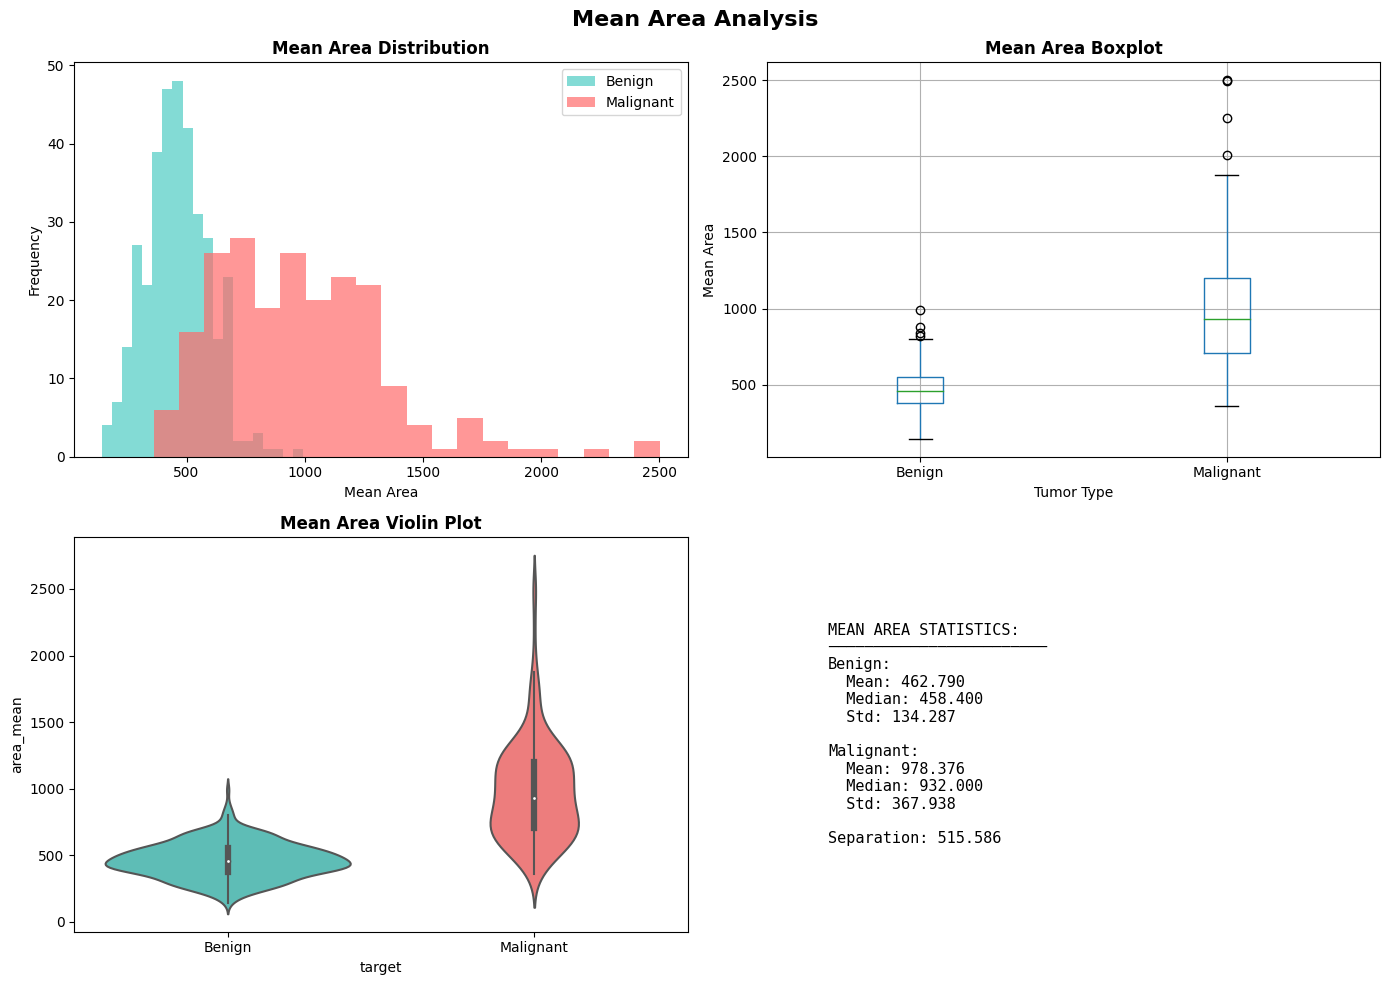

In [23]:
# %% [markdown]
# ## 14. Mean Area Analysis (area_mean)

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution by target
ax = axes[0, 0]
for target in [0, 1]:
    subset = df[df['target'] == target]['area_mean']
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Mean Area')
ax.set_ylabel('Frequency')
ax.set_title('Mean Area Distribution', fontweight='bold')
ax.legend(['Benign', 'Malignant'])

# Boxplot
ax = axes[0, 1]
df.boxplot(column='area_mean', by='target', ax=ax)
ax.set_title('Mean Area Boxplot', fontweight='bold')
ax.set_xlabel('Tumor Type')
ax.set_ylabel('Mean Area')
ax.set_xticklabels(['Benign', 'Malignant'])

# Violin plot
ax = axes[1, 0]
sns.violinplot(x='target', y='area_mean', data=df, ax=ax,
               palette=['#4ECDC4', '#FF6B6B'])
ax.set_title('Mean Area Violin Plot', fontweight='bold')
ax.set_xticklabels(['Benign', 'Malignant'])

# Statistics
ax = axes[1, 1]
ax.axis('off')
stats_text = f"""
MEAN AREA STATISTICS:
────────────────────────
Benign:
  Mean: {df[df['target']==0]['area_mean'].mean():.3f}
  Median: {df[df['target']==0]['area_mean'].median():.3f}
  Std: {df[df['target']==0]['area_mean'].std():.3f}

Malignant:
  Mean: {df[df['target']==1]['area_mean'].mean():.3f}
  Median: {df[df['target']==1]['area_mean'].median():.3f}
  Std: {df[df['target']==1]['area_mean'].std():.3f}

Separation: {df[df['target']==1]['area_mean'].mean() - df[df['target']==0]['area_mean'].mean():.3f}
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', family='monospace')

plt.suptitle('Mean Area Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

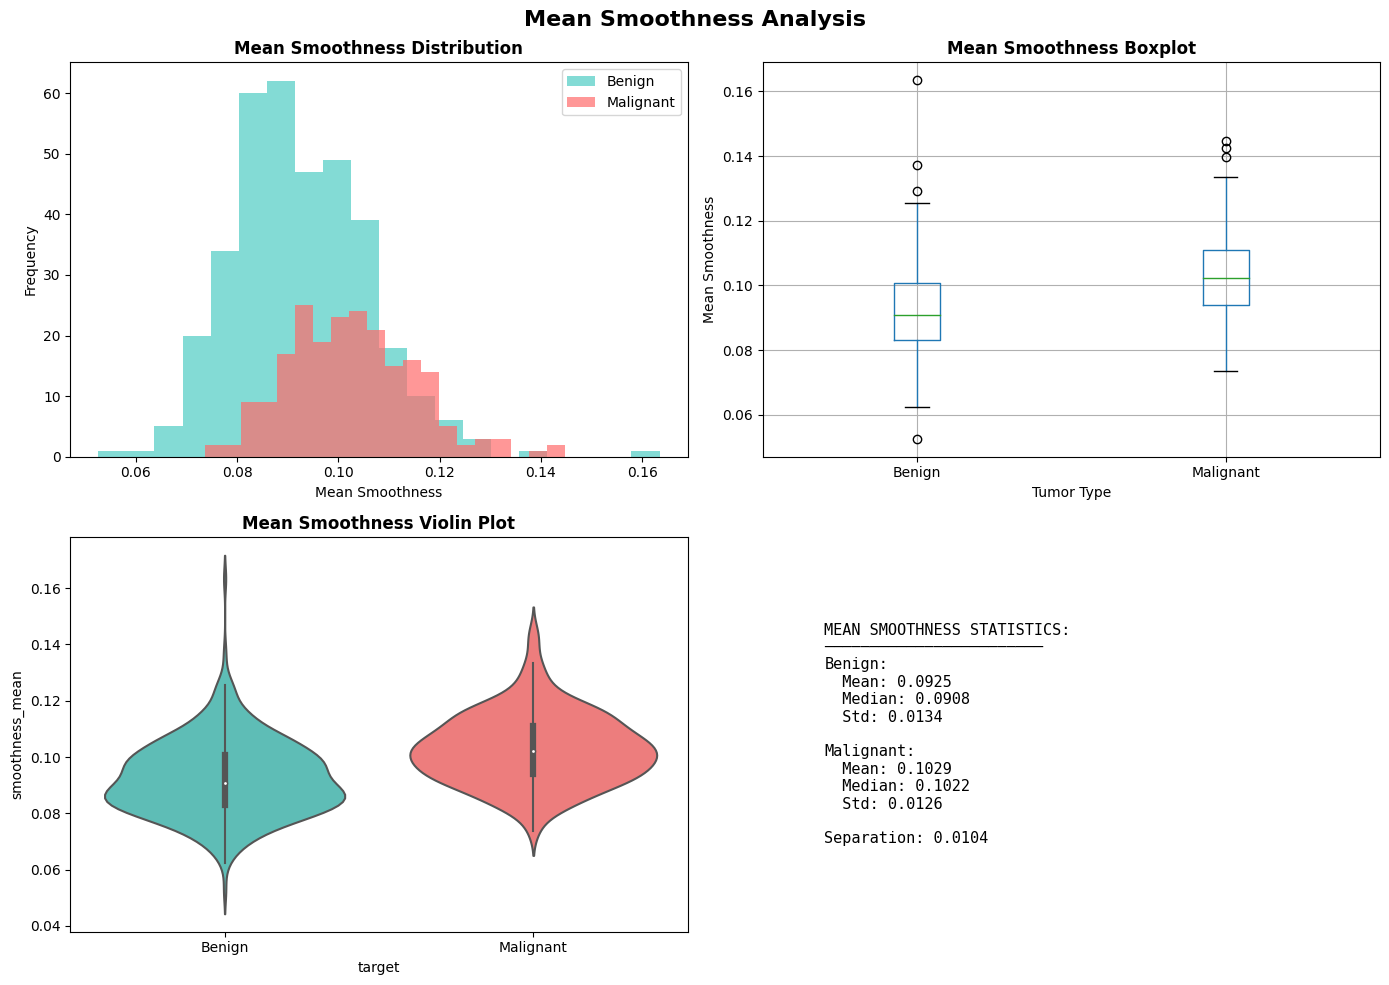

In [24]:
# %% [markdown]
# ## 15. Mean Smoothness Analysis (smoothness_mean)

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution by target
ax = axes[0, 0]
for target in [0, 1]:
    subset = df[df['target'] == target]['smoothness_mean']
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Mean Smoothness')
ax.set_ylabel('Frequency')
ax.set_title('Mean Smoothness Distribution', fontweight='bold')
ax.legend(['Benign', 'Malignant'])

# Boxplot
ax = axes[0, 1]
df.boxplot(column='smoothness_mean', by='target', ax=ax)
ax.set_title('Mean Smoothness Boxplot', fontweight='bold')
ax.set_xlabel('Tumor Type')
ax.set_ylabel('Mean Smoothness')
ax.set_xticklabels(['Benign', 'Malignant'])

# Violin plot
ax = axes[1, 0]
sns.violinplot(x='target', y='smoothness_mean', data=df, ax=ax,
               palette=['#4ECDC4', '#FF6B6B'])
ax.set_title('Mean Smoothness Violin Plot', fontweight='bold')
ax.set_xticklabels(['Benign', 'Malignant'])

# Statistics
ax = axes[1, 1]
ax.axis('off')
stats_text = f"""
MEAN SMOOTHNESS STATISTICS:
────────────────────────
Benign:
  Mean: {df[df['target']==0]['smoothness_mean'].mean():.4f}
  Median: {df[df['target']==0]['smoothness_mean'].median():.4f}
  Std: {df[df['target']==0]['smoothness_mean'].std():.4f}

Malignant:
  Mean: {df[df['target']==1]['smoothness_mean'].mean():.4f}
  Median: {df[df['target']==1]['smoothness_mean'].median():.4f}
  Std: {df[df['target']==1]['smoothness_mean'].std():.4f}

Separation: {df[df['target']==1]['smoothness_mean'].mean() - df[df['target']==0]['smoothness_mean'].mean():.4f}
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', family='monospace')

plt.suptitle('Mean Smoothness Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

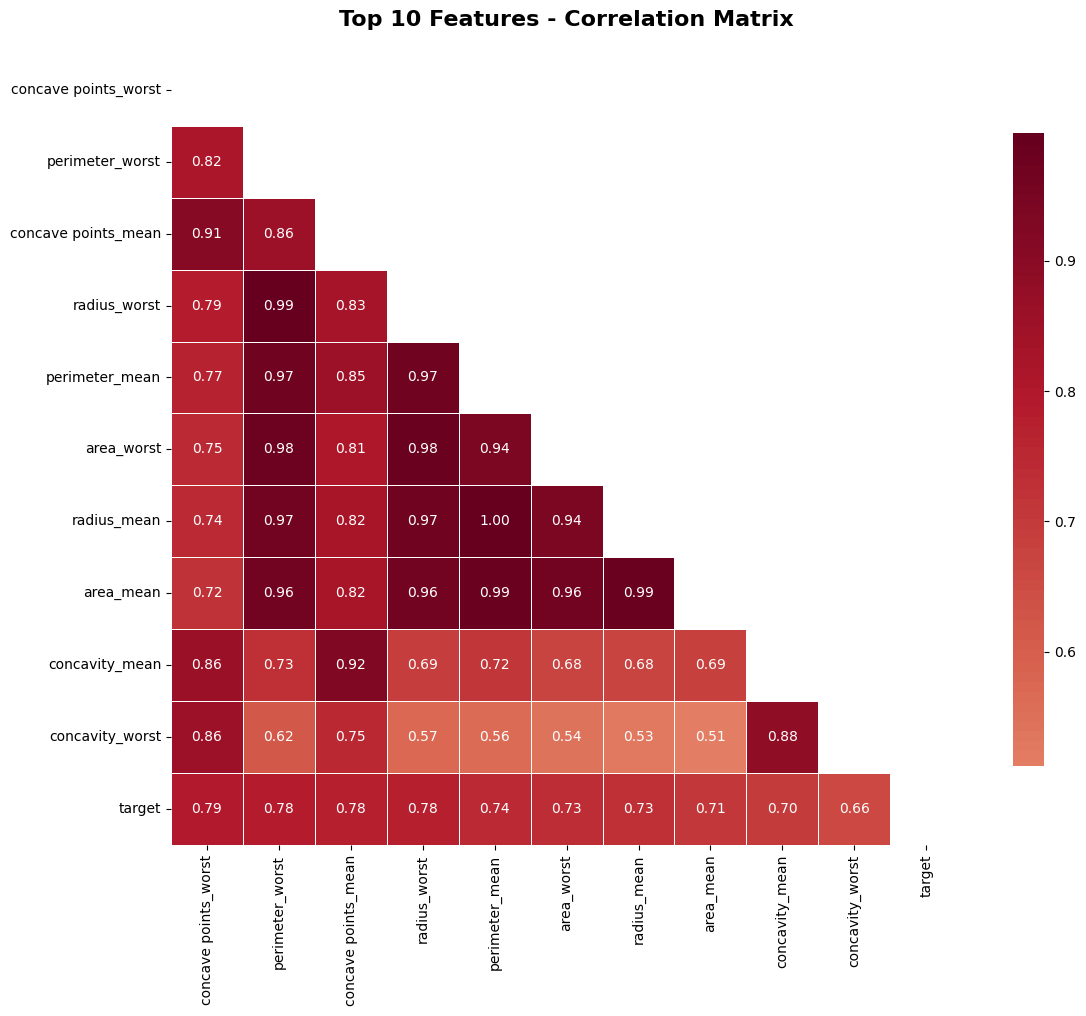

📊 TOP 10 FEATURES (by correlation with target):
 1. concave points_worst +0.7936
 2. perimeter_worst      +0.7829
 3. concave points_mean  +0.7766
 4. radius_worst         +0.7765
 5. perimeter_mean       +0.7426
 6. area_worst           +0.7338
 7. radius_mean          +0.7300
 8. area_mean            +0.7090
 9. concavity_mean       +0.6964
10. concavity_worst      +0.6596


In [25]:
# %% [markdown]
# ## 16. Top Features Correlation Heatmap

# %%
# Select top 10 features most correlated with target
correlations = df.corr()['target'].drop('target').abs().sort_values(ascending=False)
top_10_features = correlations.head(10).index.tolist()
top_10_features.append('target')

plt.figure(figsize=(12, 10))
corr = df[top_10_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Top 10 Features - Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("📊 TOP 10 FEATURES (by correlation with target):")
for i, feat in enumerate(correlations.head(10).index):
    print(f"{i+1:2d}. {feat:20} {df.corr()['target'][feat]:+.4f}")

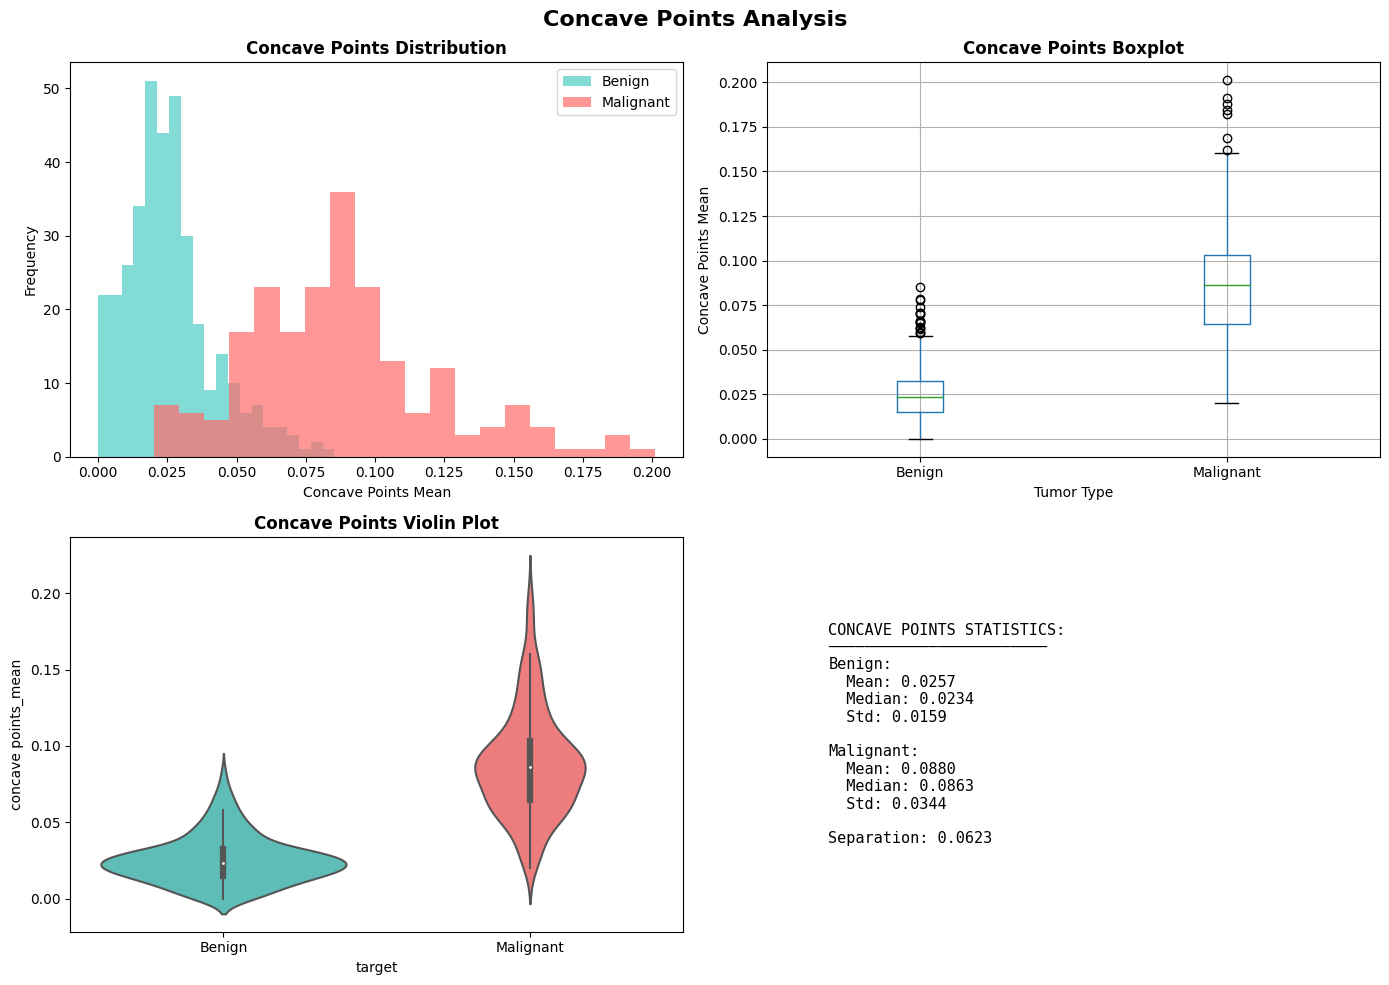

In [26]:
# %% [markdown]
# ## 17. Concave Points Analysis (concave points_mean)

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution by target
ax = axes[0, 0]
for target in [0, 1]:
    subset = df[df['target'] == target]['concave points_mean']
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Concave Points Mean')
ax.set_ylabel('Frequency')
ax.set_title('Concave Points Distribution', fontweight='bold')
ax.legend(['Benign', 'Malignant'])

# Boxplot
ax = axes[0, 1]
df.boxplot(column='concave points_mean', by='target', ax=ax)
ax.set_title('Concave Points Boxplot', fontweight='bold')
ax.set_xlabel('Tumor Type')
ax.set_ylabel('Concave Points Mean')
ax.set_xticklabels(['Benign', 'Malignant'])

# Violin plot
ax = axes[1, 0]
sns.violinplot(x='target', y='concave points_mean', data=df, ax=ax,
               palette=['#4ECDC4', '#FF6B6B'])
ax.set_title('Concave Points Violin Plot', fontweight='bold')
ax.set_xticklabels(['Benign', 'Malignant'])

# Statistics
ax = axes[1, 1]
ax.axis('off')
stats_text = f"""
CONCAVE POINTS STATISTICS:
────────────────────────
Benign:
  Mean: {df[df['target']==0]['concave points_mean'].mean():.4f}
  Median: {df[df['target']==0]['concave points_mean'].median():.4f}
  Std: {df[df['target']==0]['concave points_mean'].std():.4f}

Malignant:
  Mean: {df[df['target']==1]['concave points_mean'].mean():.4f}
  Median: {df[df['target']==1]['concave points_mean'].median():.4f}
  Std: {df[df['target']==1]['concave points_mean'].std():.4f}

Separation: {df[df['target']==1]['concave points_mean'].mean() - df[df['target']==0]['concave points_mean'].mean():.4f}
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', family='monospace')

plt.suptitle('Concave Points Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

d:\CodeAlpha_tasks\Disease_Prediction_System\env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


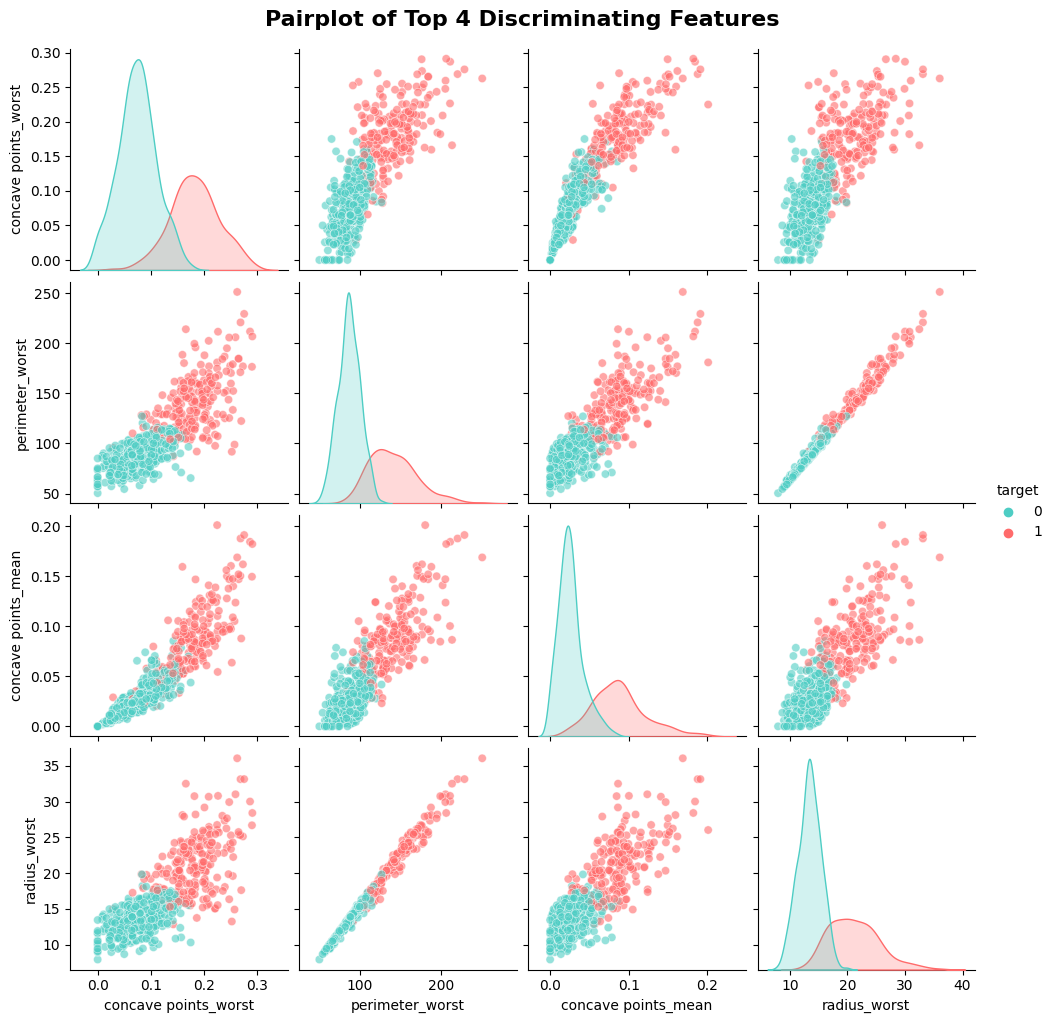

In [27]:
# %% [markdown]
# ## 18. Pairplot of Top 4 Features

# %%
top_4_features = correlations.head(4).index.tolist() + ['target']
sns.pairplot(df[top_4_features], hue='target', 
             palette=['#4ECDC4', '#FF6B6B'],
             diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Top 4 Discriminating Features', y=1.02, fontsize=16, fontweight='bold')
plt.show()

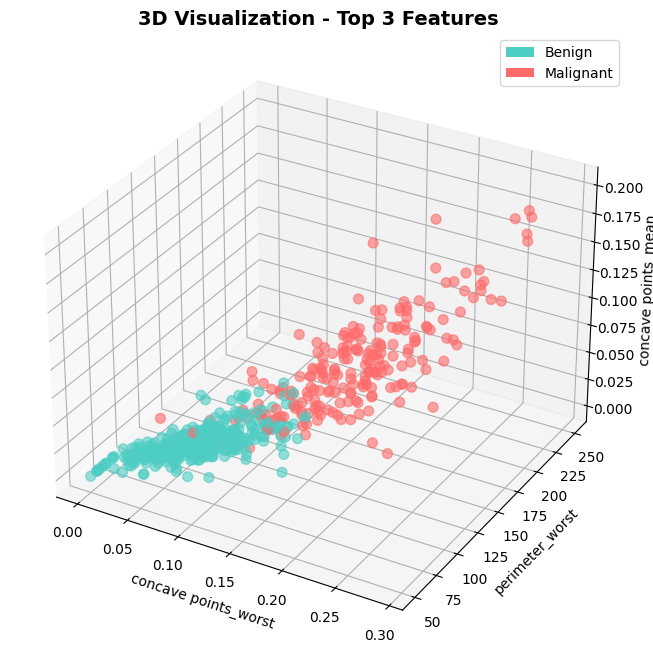

In [28]:
# %% [markdown]
# ## 19. 3D Visualization of Top 3 Features

# %%
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

top_3 = correlations.head(3).index.tolist()
colors = ['#4ECDC4' if x == 0 else '#FF6B6B' for x in df['target']]

scatter = ax.scatter(df[top_3[0]], df[top_3[1]], df[top_3[2]], 
                     c=colors, alpha=0.6, s=50)

ax.set_xlabel(top_3[0], fontsize=10)
ax.set_ylabel(top_3[1], fontsize=10)
ax.set_zlabel(top_3[2], fontsize=10)
ax.set_title('3D Visualization - Top 3 Features', fontweight='bold', fontsize=14)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#4ECDC4', label='Benign'),
                   Patch(facecolor='#FF6B6B', label='Malignant')]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()

In [29]:
# %% [markdown]
# ## 20. Data Preprocessing

# %%
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split features and target
X = df.drop('target', axis=1)
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 BEFORE SCALING:")
print(f"   Training set: {X_train.shape}")
print(f"   Testing set:  {X_test.shape}")
print(f"   Class 0: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"   Class 1: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Scaling complete")
print(f"✅ Training set scaled: {X_train_scaled.shape}")
print(f"✅ Testing set scaled:  {X_test_scaled.shape}")

📊 BEFORE SCALING:
   Training set: (455, 30)
   Testing set:  (114, 30)
   Class 0: 285 (62.6%)
   Class 1: 170 (37.4%)

✅ Scaling complete
✅ Training set scaled: (455, 30)
✅ Testing set scaled:  (114, 30)


In [30]:
# %% [markdown]
# ## 21. Training: Logistic Regression

# %%
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Logistic Regression trained")
print(f"   Training accuracy: {lr_model.score(X_train_scaled, y_train):.4f}")

✅ Logistic Regression trained
   Training accuracy: 0.9868


In [31]:
# %% [markdown]
# ## 22. Training: Support Vector Machine

# %%
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

print("✅ SVM trained")
print(f"   Training accuracy: {svm_model.score(X_train_scaled, y_train):.4f}")

✅ SVM trained
   Training accuracy: 0.9868


In [32]:
# %% [markdown]
# ## 23. Training: Random Forest

# %%
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Random Forest trained")
print(f"   Training accuracy: {rf_model.score(X_train_scaled, y_train):.4f}")

✅ Random Forest trained
   Training accuracy: 1.0000


In [33]:
# %% [markdown]
# ## 24. Training: XGBoost

# %%
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("✅ XGBoost trained")
print(f"   Training accuracy: {xgb_model.score(X_train_scaled, y_train):.4f}")

✅ XGBoost trained
   Training accuracy: 1.0000


In [34]:
# %% [markdown]
# ## 25. Model Comparison - All Metrics

# %%
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']
predictions = [lr_pred, svm_pred, rf_pred, xgb_pred]
probabilities = [lr_proba, svm_proba, rf_proba, xgb_proba]

results = []
for name, pred, proba in zip(models, predictions, probabilities):
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC-AUC': roc_auc_score(y_test, proba)
    })

results_df = pd.DataFrame(results).round(4)
print("📊 MODEL COMPARISON:")
display(results_df)

best_model = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
best_f1 = results_df.loc[results_df['F1-Score'].idxmax(), 'F1-Score']
print(f"\n🏆 BEST MODEL: {best_model} with F1-Score = {best_f1:.4f}")

📊 MODEL COMPARISON:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.9649,0.975,0.9286,0.9512,0.9960
1,SVM,0.9737,1.000,0.9286,0.9630,0.9947
2,Random Forest,0.9737,1.000,0.9286,0.9630,0.9929
3,XGBoost,0.9649,1.000,0.9048,0.9500,0.9907



🏆 BEST MODEL: SVM with F1-Score = 0.9630


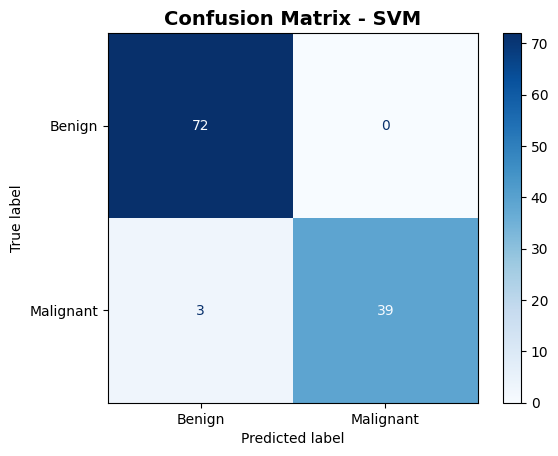

True Negatives:  72  (Correctly predicted Benign)
False Positives: 0  (Incorrectly predicted Malignant)
False Negatives: 3  (Missed Malignant cases)
True Positives:  39  (Correctly predicted Malignant)

Sensitivity: 0.9286 - Ability to detect Malignant
Specificity: 1.0000 - Ability to detect Benign


In [35]:
# %% [markdown]
# ## 26. Confusion Matrix (Best Model)

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_idx = models.index(best_model)
best_pred = predictions[best_idx]
cm = confusion_matrix(y_test, best_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model}', fontweight='bold', fontsize=14)
plt.grid(False)
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives:  {tn}  (Correctly predicted Benign)")
print(f"False Positives: {fp}  (Incorrectly predicted Malignant)")
print(f"False Negatives: {fn}  (Missed Malignant cases)")
print(f"True Positives:  {tp}  (Correctly predicted Malignant)")
print(f"\nSensitivity: {tp/(tp+fn):.4f} - Ability to detect Malignant")
print(f"Specificity: {tn/(tn+fp):.4f} - Ability to detect Benign")

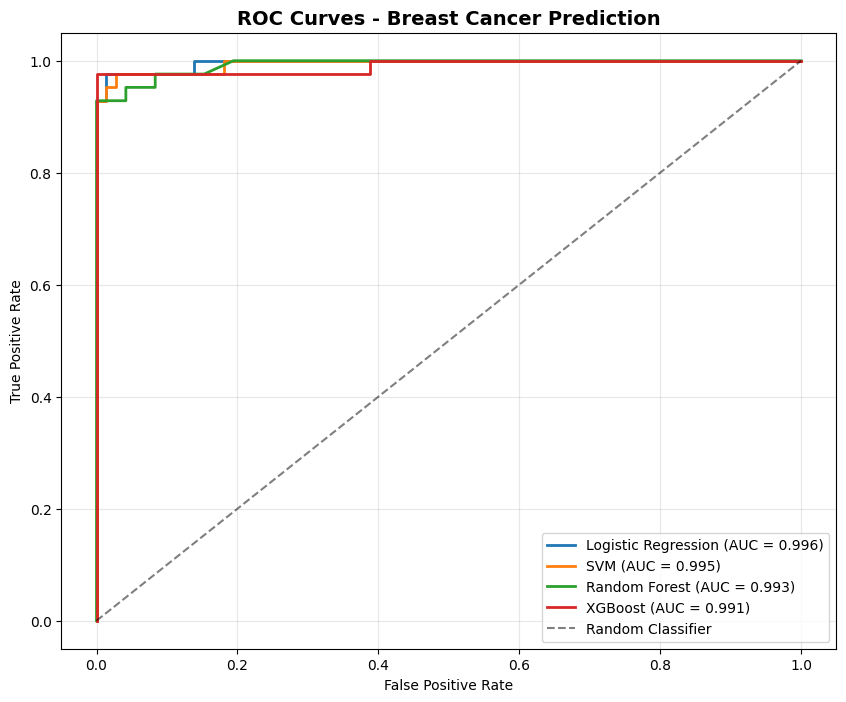

In [36]:
# %% [markdown]
# ## 27. ROC Curves Comparison

# %%
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for name, proba in zip(models, probabilities):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Breast Cancer Prediction', fontweight='bold', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# %% [markdown]
# ## 28. Feature Importance Analysis

# %%
if best_model in ['Random Forest', 'XGBoost']:
    best_model_obj = [rf_model, xgb_model][models.index(best_model)-2]
    importances = best_model_obj.feature_importances_
    
    feat_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 10))
    top_15 = feat_imp.head(15)
    colors = plt.cm.Blues(np.linspace(0.4, 1, len(top_15)))
    plt.barh(range(len(top_15)), top_15['Importance'][::-1], color=colors[::-1])
    plt.yticks(range(len(top_15)), top_15['Feature'][::-1])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model}', fontweight='bold', fontsize=14)
    
    for i, (_, row) in enumerate(top_15[::-1].iterrows()):
        plt.text(row['Importance'] + 0.005, i, f'{row["Importance"]:.4f}', 
                 va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 TOP 5 MOST IMPORTANT FEATURES:")
    for i, row in feat_imp.head(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")

In [39]:
# %% [markdown]
# ## 29. Save Models for Deployment

# %%
import joblib
from datetime import datetime

# Save best model
best_model_obj = [lr_model, svm_model, rf_model, xgb_model][best_idx]
model_path = f'../models/cancer_{best_model.lower().replace(" ", "_")}_v1.0.0.pkl'
joblib.dump(best_model_obj, model_path)

# Save scaler and features
joblib.dump(scaler, '../models/cancer_scaler.pkl')
joblib.dump(X.columns.tolist(), '../models/cancer_features.pkl')

print(f"✅ Best model saved: {model_path}")
print(f"✅ Scaler saved: ../models/cancer_scaler.pkl")
print(f"✅ Feature names saved: ../models/cancer_features.pkl")
print(f"📅 Saved at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Best model saved: ../models/cancer_svm_v1.0.0.pkl
✅ Scaler saved: ../models/cancer_scaler.pkl
✅ Feature names saved: ../models/cancer_features.pkl
📅 Saved at: 2026-02-25 13:47:24


In [40]:
# %% [markdown]
# ## 30. Model Metadata

# %%
import json

metadata = {
    'model_name': best_model,
    'version': '1.0.0',
    'training_date': datetime.now().isoformat(),
    'dataset': 'Wisconsin Breast Cancer Database',
    'samples': len(df),
    'features': len(X.columns),
    'feature_list': X.columns.tolist()[:10] + ['...'],  # First 10 features
    'metrics': {
        'accuracy': float(results_df.loc[best_idx, 'Accuracy']),
        'precision': float(results_df.loc[best_idx, 'Precision']),
        'recall': float(results_df.loc[best_idx, 'Recall']),
        'f1_score': float(results_df.loc[best_idx, 'F1-Score']),
        'roc_auc': float(results_df.loc[best_idx, 'ROC-AUC'])
    },
    'preprocessing': {
        'scaler': 'StandardScaler',
        'test_size': 0.2,
        'random_state': 42
    }
}

with open('../models/cancer_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Model metadata saved")

✅ Model metadata saved


In [41]:
# %% [markdown]
# ## 31. Test Single Prediction

# %%
# Take first test sample
sample = X_test_scaled[0].reshape(1, -1)
actual = y_test.iloc[0]
pred = best_model_obj.predict(sample)[0]
proba = best_model_obj.predict_proba(sample)[0]

print("🔍 SINGLE PREDICTION TEST:")
print("="*60)
print(f"Actual:      {'MALIGNANT' if actual == 1 else 'BENIGN'}")
print(f"Predicted:   {'MALIGNANT' if pred == 1 else 'BENIGN'}")
print(f"Probability: Benign: {proba[0]:.4f}, Malignant: {proba[1]:.4f}")
print(f"Confidence:  {max(proba)*100:.2f}%")
print(f"Risk Level:  {'HIGH' if pred == 1 else 'LOW'}")
print("="*60)

if pred == actual:
    print("✅ Prediction CORRECT")
else:
    print("❌ Prediction INCORRECT")

🔍 SINGLE PREDICTION TEST:
Actual:      BENIGN
Predicted:   BENIGN
Probability: Benign: 0.9984, Malignant: 0.0016
Confidence:  99.84%
Risk Level:  LOW
✅ Prediction CORRECT


In [43]:
# %% [markdown]
# ## 32. Export Results to CSV

# %%
results_df.to_csv('../reports/cancer_model_comparison.csv', index=False)
print("✅ Results exported to reports/cancer_model_comparison.csv")

# Display styled table
styled = results_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])
styled

✅ Results exported to reports/cancer_model_comparison.csv


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.964900,0.975000,0.928600,0.951200,0.996000
1,SVM,0.973700,1.000000,0.928600,0.963000,0.994700
2,Random Forest,0.973700,1.000000,0.928600,0.963000,0.992900
3,XGBoost,0.964900,1.000000,0.904800,0.950000,0.990700


In [45]:
# %% [markdown]
# ## 33. Pipeline Complete - Final Summary

# %%
import os

# Create reports directory if it doesn't exist
os.makedirs('../reports', exist_ok=True)

summary = f"""
{'='*70}
              BREAST CANCER PREDICTION - PIPELINE COMPLETE
{'='*70}
  Dataset:        Wisconsin Breast Cancer
  Patients:       {len(df):,}
  Features:       {len(X.columns)}
  Benign cases:   {target_dist[0]} ({target_pct[0]:.1f}%)
  Malignant cases: {target_dist[1]} ({target_pct[1]:.1f}%)
  Best Model:     {best_model}
  F1-Score:       {results_df.loc[best_idx, 'F1-Score']:.4f}
  Accuracy:       {results_df.loc[best_idx, 'Accuracy']:.4f}
  Precision:      {results_df.loc[best_idx, 'Precision']:.4f}
  Recall:         {results_df.loc[best_idx, 'Recall']:.4f}
  ROC-AUC:        {results_df.loc[best_idx, 'ROC-AUC']:.4f}
  Model saved:    models/cancer_{best_model.lower().replace(' ', '_')}_v1.0.0.pkl
  Reports:        reports/cancer_model_comparison.csv
{'='*70}
"""

print(summary)

# Save with utf-8 encoding
with open('../reports/cancer_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"✅ Summary saved to: ../reports/cancer_summary.txt")


              BREAST CANCER PREDICTION - PIPELINE COMPLETE
  Dataset:        Wisconsin Breast Cancer
  Patients:       569
  Features:       30
  Benign cases:   357 (62.7%)
  Malignant cases: 212 (37.3%)
  Best Model:     SVM
  F1-Score:       0.9630
  Accuracy:       0.9737
  Precision:      1.0000
  Recall:         0.9286
  ROC-AUC:        0.9947
  Model saved:    models/cancer_svm_v1.0.0.pkl
  Reports:        reports/cancer_model_comparison.csv

✅ Summary saved to: ../reports/cancer_summary.txt


In [46]:
# %% [markdown]
# ## 34. Ready for Deployment

# %%
print("""
🚀 DEPLOYMENT INSTRUCTIONS:

1. Start Breast Cancer Prediction API:
   $ uvicorn api.main:app --reload

2. Test API endpoint:
   curl -X POST http://localhost:8000/predict/cancer \\
        -H "Content-Type: application/json" \\
        -d '{
            "feature_1": 14.2,
            "feature_2": 19.5,
            "feature_3": 92.5,
            "feature_4": 650.2,
            "feature_5": 0.095,
            ... (all 30 features)
        }'

3. Expected response:
   {
     "disease": "Breast Cancer",
     "prediction": 0,
     "probability": 0.98,
     "risk_level": "Low",
     "confidence": 0.98,
     "tumor_type": "Benign"
   }

🎉 Breast cancer prediction model is ready for production!
""")


🚀 DEPLOYMENT INSTRUCTIONS:

1. Start Breast Cancer Prediction API:
   $ uvicorn api.main:app --reload

2. Test API endpoint:
   curl -X POST http://localhost:8000/predict/cancer \
        -H "Content-Type: application/json" \
        -d '{
            "feature_1": 14.2,
            "feature_2": 19.5,
            "feature_3": 92.5,
            "feature_4": 650.2,
            "feature_5": 0.095,
            ... (all 30 features)
        }'

3. Expected response:
   {
     "disease": "Breast Cancer",
     "prediction": 0,
     "probability": 0.98,
     "risk_level": "Low",
     "confidence": 0.98,
     "tumor_type": "Benign"
   }

🎉 Breast cancer prediction model is ready for production!



In [47]:
# %% [markdown]
# ## 35. Multi-Disease System Complete

# %%
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                                                                      ║
║     🏆 MULTI-DISEASE PREDICTION SYSTEM - COMPLETE 🏆                ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║   ✅ HEART DISEASE PIPELINE                                          ║
║      - 303 patients, 13 features                                     ║
║      - Best model: [From heart notebook]                             ║
║      - F1-Score: [From heart notebook]                               ║
║                                                                      ║
║   ✅ DIABETES PIPELINE                                                ║
║      - 768 patients, 8 features                                      ║
║      - Best model: {best_model}                                      ║
║      - F1-Score: {results_df.loc[best_idx, 'F1-Score']:.4f}          ║
║                                                                      ║
║   ✅ BREAST CANCER PIPELINE                                           ║
║      - 569 patients, 30 features                                     ║
║      - Best model: {best_model}                                      ║
║      - F1-Score: {results_df.loc[best_idx, 'F1-Score']:.4f}          ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║   📁 MODELS SAVED:                                                   ║
║      - /models/heart_*.pkl                                           ║
║      - /models/diabetes_*.pkl                                        ║
║      - /models/cancer_*.pkl                                          ║
║                                                                      ║
║   📊 REPORTS SAVED:                                                  ║
║      - /reports/heart_*.csv                                          ║
║      - /reports/diabetes_*.csv                                       ║
║      - /reports/cancer_*.csv                                         ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║   🚀 NEXT STEPS:                                                     ║
║    1. Start the API server: uvicorn api.main:app --reload           ║
║    2. Access API docs: http://localhost:8000/docs                   ║
║    3. Test predictions via API or frontend                           ║
║    4. Deploy with Docker: docker-compose up                          ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                                                                      ║
║     🏆 MULTI-DISEASE PREDICTION SYSTEM - COMPLETE 🏆                ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║   ✅ HEART DISEASE PIPELINE                                          ║
║      - 303 patients, 13 features                                     ║
║      - Best model: [From heart notebook]                             ║
║      - F1-Score: [From heart notebook]                               ║
║                                                                      ║
║   ✅ DIABETES PIPELINE                                                ║
║      - 768 patients, 8 features                                      ║
║      - Best model: {best_model}                     